In [56]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc


plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = (10, 5)

In [57]:
x=np.fromfile("TM1_15RB_FDD.dat",dtype=np.complex64)
fs=3.84e6
ts=1/fs
f=np.fft.fftshift(np.fft.fftfreq(len(x),ts))
t=np.linspace(0,len(x)*ts,len(x))
len(x)

38400

<img src="TM1_15RB_FDD.bmp">


In [58]:
espec=np.log10(np.abs(np.fft.fftshift(np.fft.fft(x))))

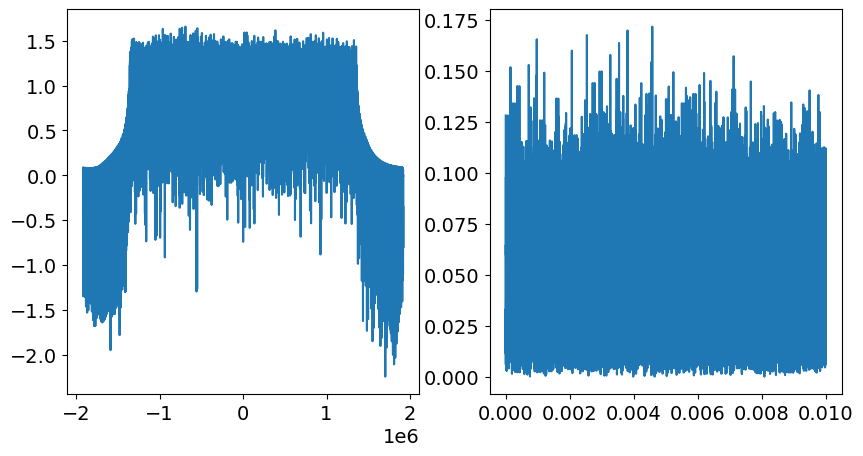

In [59]:
plt.subplot(1,2,1)
plt.plot(f,espec)
plt.subplot(1,2,2)
plt.plot(t,np.abs(x))

# parametros LTE

<img src="parametros4G.png">


In [60]:
# The units here are samples
Tu = 256 # useful time of a symbol
cp_len = round(fs*4.7e-6)  # 4.7 usecs, used in symbols 1-6 in a slot
cp_len2 = round(fs*5.2e-6)  # 5.2 usecs, used in symbol 0 in a slot


print("cp_len=", cp_len, "muestras")
print("cp_len2=",cp_len2, "muestras")

cp_len= 18 muestras
cp_len2= 20 muestras


# PSS

<img src="pss.png">

In [61]:
# La PSS ocupa 3RB a cada lado del DC y deja 5RE sin potencia a 
# 6*12

subcarriers_ss = slice(Tu//2 - 3*12 + 5, Tu//2 + 3*12 - 5 + 1)
print("subcarriers",Tu//2 - 3*12 + 5, "a",Tu//2 + 3*12 - 5 + 1, " el SSB ocupa ", (Tu//2 + 3*12 - 5 + 1) - (Tu//2 - 3*12 + 5),"portadoras" )

subcarriers 97 a 160  el SSB ocupa  63 portadoras


In [62]:
def zadoff_chu(u):
    n = np.arange(63)
    a = np.exp(-1j*np.pi*u*n[0:31]*(n[0:31]+1)/63)
    b = np.asarray([0])  # This corresponds to the DC subcarrier
    c = np.exp(-1j*np.pi*u*(n[31:62]+1)*(n[31:62]+2)/63)
    x=np.concatenate((a,b,c))
    return x

print (len(zadoff_chu(25)))



63


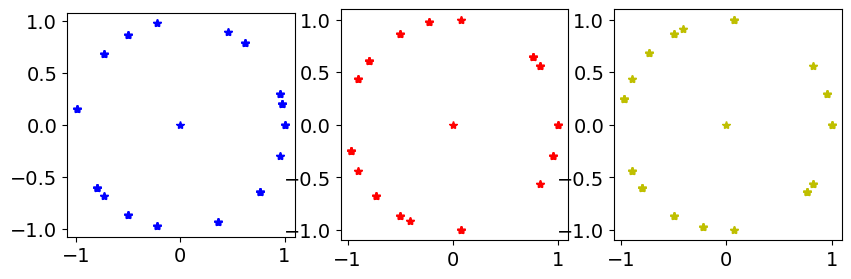

In [63]:
plt.subplot(1,3,1)
plt.plot(zadoff_chu(25).real,zadoff_chu(25).imag,"*b")
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1,3,2)
plt.plot(zadoff_chu(29).real,zadoff_chu(29).imag,"*r")
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1,3,3)
plt.plot(zadoff_chu(34).real,zadoff_chu(34).imag,"*y")
plt.gca().set_aspect('equal', adjustable='box')


In [64]:
zc_u = [25, 29, 34]
zc_time = np.empty((3, Tu), 'complex')
for j in range(3):
    zc = zadoff_chu(zc_u[j])
    zc_all = np.zeros(Tu, 'complex')
    zc_all[subcarriers_ss] = zc
    zc_time[j] = np.fft.ifft(np.fft.fftshift(zc_all))

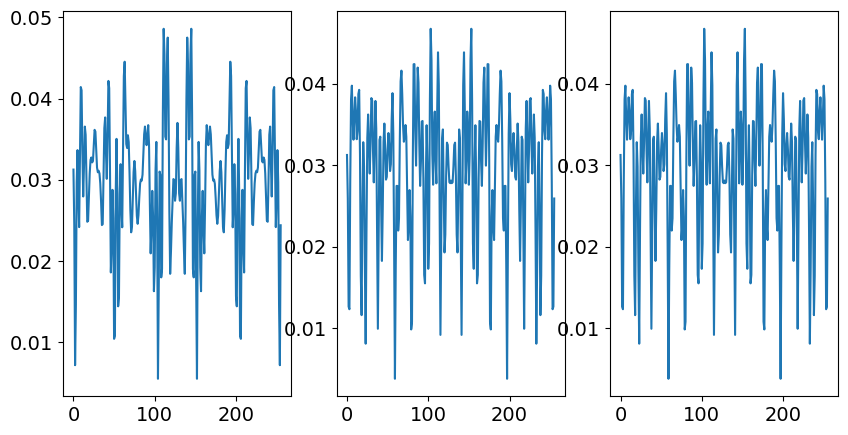

In [65]:
plt.subplot(1,3,1)
plt.plot(np.abs(zc_time[0]))
plt.subplot(1,3,2)
plt.plot(np.abs(zc_time[1]))
plt.subplot(1,3,3)
plt.plot(np.abs(zc_time[2]))

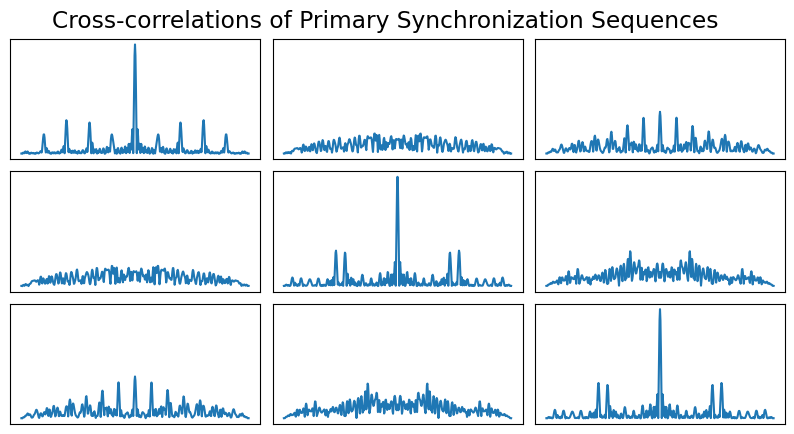

In [66]:
fig, axs = plt.subplots(3, 3, facecolor='w', sharex=True, sharey=True)
for j in range(3):
    for k in range(3):
        axs[j, k].plot(np.abs(np.correlate(zc_time[j], zc_time[k], mode='full')))
        axs[j, k].set_xticks([])
        axs[j, k].set_yticks([])
plt.suptitle('Cross-correlations of Primary Synchronization Sequences', y=0.94)
plt.subplots_adjust(wspace=0.05, hspace=0.1)

el pico de correlacion se encuentra en la muestra  1792  en el tiempo  0.0004666788197609313


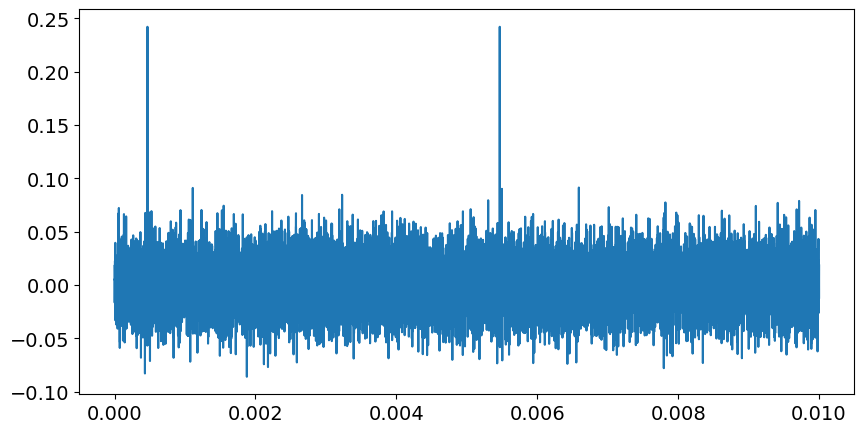

In [67]:
micorrelacion=np.correlate(zc_time[1],x,mode="same")
micorrelacion=micorrelacion[::-1]
plt.plot(t,(micorrelacion.real))

pico=np.argmax(micorrelacion[0:len(micorrelacion)//2])
picot=t[pico]

print("el pico de correlacion se encuentra en la muestra ",pico , " en el tiempo ", picot)


(0.00041667881976093125, 0.0005166788197609312)

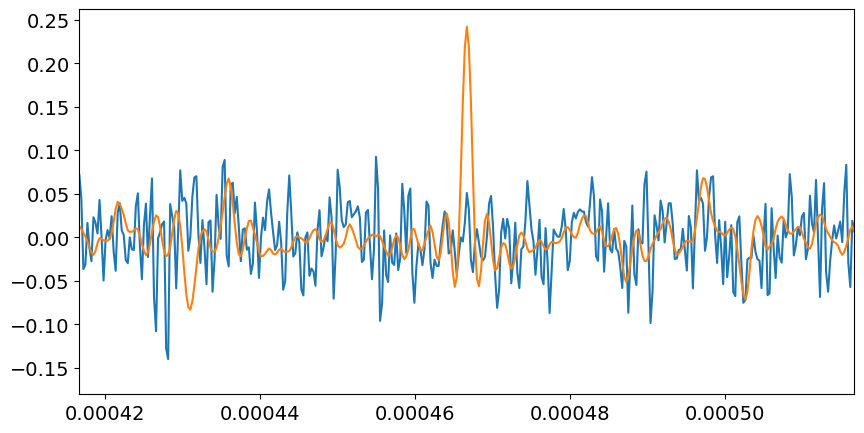

In [68]:
plt.plot(t,x)
plt.plot(t,micorrelacion)
plt.xlim([picot-50e-6,picot+50e-6])

In [69]:
print("pisicion de pss en la trama",(Tu+cp_len2+6*(Tu+cp_len))*ts*1e6)
print("pisicion de pss en la trama en muestras",(Tu+cp_len2+6*(Tu+cp_len)))

print("posicion detectada", picot*1e6)
print("posicion detectada en muestras", pico)

pisicion de pss en la trama 500.0
pisicion de pss en la trama en muestras 1920
posicion detectada 466.6788197609313
posicion detectada en muestras 1792


63

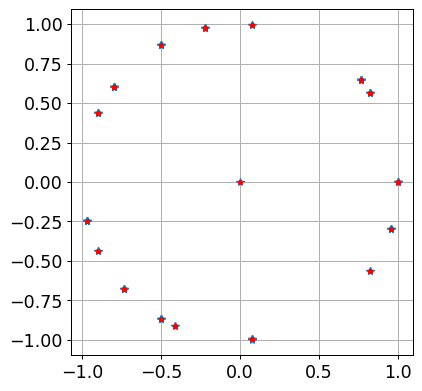

In [70]:
r=pico-Tu//2

syms = np.fft.fftshift(np.fft.fft(x[r:r+Tu]))
plt.figure(dpi=90)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(syms[subcarriers_ss].real,syms[subcarriers_ss].imag,"*")
plt.plot(zadoff_chu(29).real,zadoff_chu(29).imag,".r")
plt.grid(True)



len(syms[subcarriers_ss])
len(zadoff_chu(29))

# SSS

In [93]:
# La SSS ocupa 3RB a cada lado del DC y deja 5RE sin potencia a 
# 6*12

subcarriers_sss = slice(Tu//2 - 3*12 , Tu//2 + 3*12 + 1)
print("subcarriers",Tu//2 - 3*12 , "a",Tu//2 + 3*12 + 1, " el SSB ocupa ", (Tu//2 + 3*12  + 1) - (Tu//2 - 3*12 ),"portadoras" )

subcarriers 92 a 165  el SSB ocupa  73 portadoras


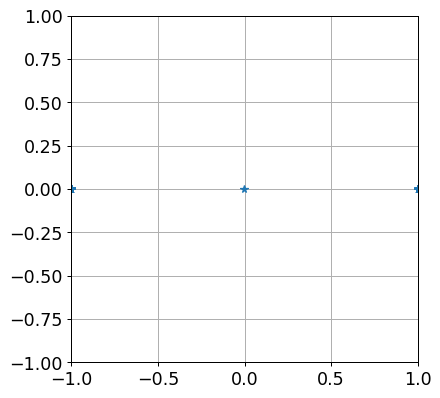

In [94]:
s=r-cp_len-Tu

syms = np.fft.fftshift(np.fft.fft(x[s:s+Tu]))
plt.figure(dpi=90)
plt.plot(syms[subcarriers_ss].real,syms[subcarriers_ss].imag,"*")
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.grid(True)


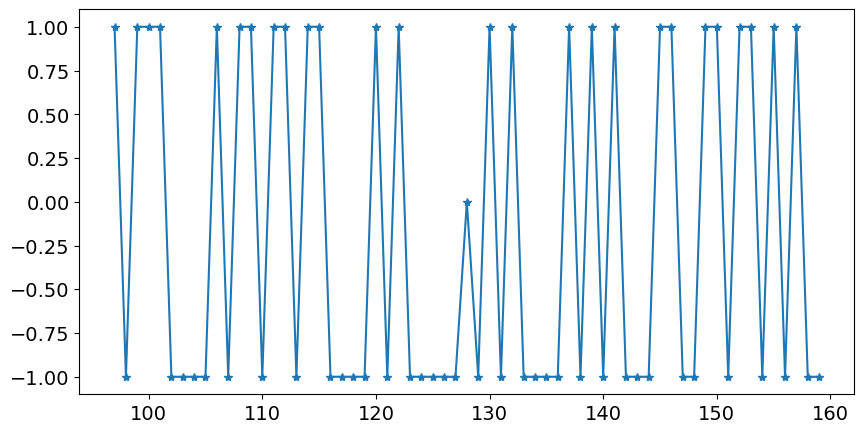

In [95]:
plt.plot(range(Tu)[subcarriers_ss],syms[subcarriers_ss],"-*")


In [76]:
20+256+(18+256)*4+18


1390

In [85]:
r-256-18

np.int64(1390)